/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
08/20/2025 15:30:03:WARNING:Ignoring drop_last as it is not compatible with DPDataLoader.


Device: cpu
Train size: 1920 | Val size: 480
Epoch 01 | train loss 1.683 acc 0.27 | val loss 1.645 acc 0.34 | ε=1.58 σ=1.00
Epoch 02 | train loss 1.509 acc 0.37 | val loss 1.450 acc 0.41 | ε=1.96 σ=1.00
Epoch 03 | train loss 1.411 acc 0.43 | val loss 1.447 acc 0.43 | ε=2.27 σ=1.00
Epoch 04 | train loss 1.346 acc 0.44 | val loss 1.331 acc 0.40 | ε=2.53 σ=1.00
Epoch 05 | train loss 1.273 acc 0.44 | val loss 1.288 acc 0.45 | ε=2.77 σ=1.00
Epoch 06 | train loss 1.214 acc 0.45 | val loss 1.225 acc 0.46 | ε=3.00 σ=1.00
Epoch 07 | train loss 1.156 acc 0.48 | val loss 1.259 acc 0.44 | ε=3.21 σ=1.00
Epoch 08 | train loss 1.166 acc 0.48 | val loss 1.203 acc 0.46 | ε=3.40 σ=1.00
Epoch 09 | train loss 1.097 acc 0.53 | val loss 1.279 acc 0.48 | ε=3.59 σ=1.00
Epoch 10 | train loss 1.125 acc 0.52 | val loss 1.214 acc 0.48 | ε=3.77 σ=1.00
Epoch 11 | train loss 1.085 acc 0.55 | val loss 1.196 acc 0.51 | ε=3.94 σ=1.00
Epoch 12 | train loss 1.074 acc 0.54 | val loss 1.356 acc 0.50 | ε=4.11 σ=1.00
Epoch 1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


  ↑ Increasing noise to σ=3.40 (ε=6.64) to slow growth.
Epoch 40 | train loss 2.555 acc 0.50 | val loss 2.860 acc 0.45 | ε=6.64 σ=3.40
Saved model -> dp_emotion_model.pth
Saved metrics -> ../results/dp_run_1755696603.csv


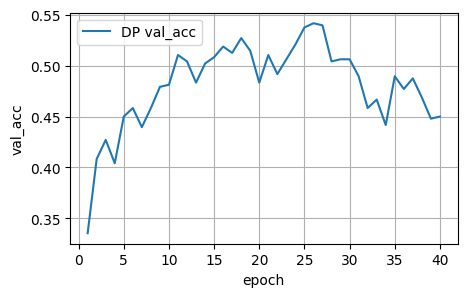

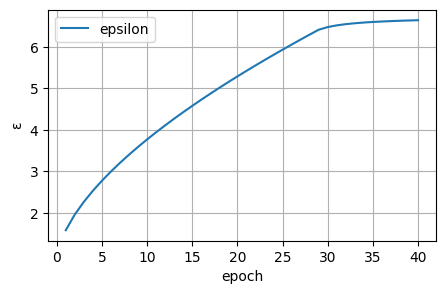

[Non-DP] Epoch 1 | train_acc 0.29 | val_acc 0.57
[Non-DP] Epoch 2 | train_acc 0.46 | val_acc 0.48
[Non-DP] Epoch 3 | train_acc 0.52 | val_acc 0.55
Saved non-DP metrics -> ../results/ndp_baseline_1755696614.csv


In [11]:
# =================== DP-SGD COMPLETE TRAINER (JUPYTER) ===================
# Runs on CPU or GPU, creates separable synthetic data, trains with Opacus,
# adapts noise before logging, logs to CSV, saves model, plots, and runs a
# short non-DP baseline for comparison.

import os, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from opacus import PrivacyEngine

# -------------------- Config & Environment --------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Adjust relative path if your notebook is at repo root
RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# DP targets
delta = 1e-5            # or set to 1.0 / N_train
target_epsilon = 8.0     # privacy budget cap
max_grad_norm = 1.0
noise_multiplier = 1.0   # will adapt upward

LOWER_TRIGGER = 0.80     # start adapting at 80% of target ε
UPPER_TRIGGER = 0.90     # optional second tier at 90%

EPOCHS = 40              # give enough room so adaptation can take effect
BATCH_SIZE = 64

# -------------------- Data (Separable Synthetic) --------------------
# We create class-separable synthetic data so you can see real learning.
# Later you can replace this with real embeddings (faces/physio) without changing the rest.
def make_separable_data(n_total=2400, d=128, n_classes=6, per_class_shift=2.0, cov_scale=0.8, seed=SEED):
    torch.manual_seed(seed)
    samples_per_class = n_total // n_classes
    Xs, ys = [], []
    for k in range(n_classes):
        mean = torch.zeros(d)
        mean[:8] = (k + 1) * per_class_shift   # shift first few dims by class to be separable
        cov = torch.eye(d) * cov_scale
        Xk = torch.randn(samples_per_class, d) @ cov.sqrt() + mean
        yk = torch.full((samples_per_class,), k, dtype=torch.long)
        Xs.append(Xk); ys.append(yk)
    X = torch.vstack(Xs); y = torch.hstack(ys)
    return X, y

D_IN, N_CLASSES = 128, 6
X_all, y_all = make_separable_data(n_total=2400, d=D_IN, n_classes=N_CLASSES)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.2, stratify=y_all.numpy(), random_state=SEED
)
X_tr, y_tr = torch.from_numpy(X_tr).float(), torch.from_numpy(y_tr).long()
X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()

train_ds = TensorDataset(X_tr, y_tr)
val_ds   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")

# -------------------- Model --------------------
class EmotionNet(nn.Module):
    def __init__(self, d_in=128, d_h=64, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_h), nn.ReLU(),
            nn.Linear(d_h, num_classes)
        )
    def forward(self, x): return self.net(x)

model = EmotionNet(D_IN, 64, N_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# -------------------- Attach Opacus (DP-SGD) --------------------
privacy_engine = PrivacyEngine(secure_mode=False)  # set True for your final "production" retrain
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=noise_multiplier,
    max_grad_norm=max_grad_norm,
)

assert hasattr(optimizer, "noise_multiplier"), "Opacus optimizer should have noise_multiplier attribute."

# -------------------- Helpers --------------------
def eval_metrics(m, dl):
    m.eval()
    y_true, y_pred, losses = [], [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = m(xb)
            losses.append(criterion(logits, yb).item())
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
    return float(np.mean(losses)), float(accuracy_score(y_true, y_pred))

# -------------------- Training with Adaptive Noise --------------------
run_id = int(time.time())
log_path = os.path.join(RESULTS_DIR, f"dp_run_{run_id}.csv")
rows = []

# choose delta = 1/|train| if you prefer that convention
# delta = 1.0 / len(train_ds)

for epoch in range(1, EPOCHS+1):
    # ---- train ----
    model.train()
    batch_losses, tr_true, tr_pred = [], [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        tr_true.extend(yb.detach().cpu().numpy())
        tr_pred.extend(logits.argmax(1).detach().cpu().numpy())

    train_loss = float(np.mean(batch_losses))
    train_acc  = float(accuracy_score(tr_true, tr_pred))

    # ---- privacy spent so far ----
    eps = privacy_engine.get_epsilon(delta)

    # ---- adapt BEFORE logging/printing so σ appears updated ----
    if eps > target_epsilon:
        print(f"Epoch {epoch:02d} | Reached target ε={eps:.2f} (> {target_epsilon}); stopping.")
        break

    if eps > LOWER_TRIGGER * target_epsilon:
        noise_multiplier += 0.2
        optimizer.noise_multiplier = noise_multiplier  # apply to Opacus
        print(f"  ↑ Increasing noise to σ={noise_multiplier:.2f} (ε={eps:.2f}) to slow growth.")
    if eps > UPPER_TRIGGER * target_epsilon:
        noise_multiplier += 0.2
        optimizer.noise_multiplier = noise_multiplier
        print(f"  ↑ [Tier2] Increasing noise to σ={noise_multiplier:.2f} (ε={eps:.2f})")

    # ---- validate & log ----
    val_loss, val_acc = eval_metrics(model, val_loader)
    sigma_now = optimizer.noise_multiplier  # authoritative source

    print(f"Epoch {epoch:02d} | train loss {train_loss:.3f} acc {train_acc:.2f} | "
          f"val loss {val_loss:.3f} acc {val_acc:.2f} | ε={eps:.2f} σ={sigma_now:.2f}")

    rows.append({
        "epoch": epoch,
        "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss,     "val_acc": val_acc,
        "epsilon": float(eps), "delta": delta,
        "noise_multiplier": float(sigma_now),
        "max_grad_norm": max_grad_norm,
        "batch_size": train_loader.batch_size,
    })

# -------------------- Save artifacts --------------------
model_path = "dp_emotion_model.pth"
torch.save(model.state_dict(), model_path)
pd.DataFrame(rows).to_csv(log_path, index=False)
print("Saved model ->", model_path)
print("Saved metrics ->", log_path)

# -------------------- Quick plots --------------------
dp = pd.read_csv(log_path)
plt.figure(figsize=(5,3)); plt.plot(dp["epoch"], dp["val_acc"], label="DP val_acc")
plt.xlabel("epoch"); plt.ylabel("val_acc"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(5,3)); plt.plot(dp["epoch"], dp["epsilon"], label="epsilon")
plt.xlabel("epoch"); plt.ylabel("ε"); plt.grid(True); plt.legend(); plt.show()

# -------------------- Short Non-DP baseline (3 epochs) --------------------
# (same data & model arch; no Opacus)
model_ndp = EmotionNet(D_IN, 64, N_CLASSES).to(device)
opt = optim.SGD(model_ndp.parameters(), lr=0.05, momentum=0.9)

rows_ndp = []
for e in range(1, 4):
    model_ndp.train()
    bl, ttrue, tpred = [], [], []
    for xb, yb in DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        out = model_ndp(xb); loss = criterion(out, yb)
        loss.backward(); opt.step()
        bl.append(loss.item())
        ttrue.extend(yb.detach().cpu().numpy())
        tpred.extend(out.argmax(1).detach().cpu().numpy())
    tr_acc = float(accuracy_score(ttrue, tpred))
    vl_loss, vl_acc = eval_metrics(model_ndp, val_loader)
    print(f"[Non-DP] Epoch {e} | train_acc {tr_acc:.2f} | val_acc {vl_acc:.2f}")
    rows_ndp.append({"epoch": e, "train_acc": tr_acc, "val_acc": vl_acc})

ndp_csv = os.path.join(RESULTS_DIR, f"ndp_baseline_{int(time.time())}.csv")
pd.DataFrame(rows_ndp).to_csv(ndp_csv, index=False)
print("Saved non-DP metrics ->", ndp_csv)
# ========================================================================

In [ ]:
# Save model & log
torch.save(model.state_dict(), "dp_emotion_model.pth")
pd.DataFrame(rows).to_csv(log_path, index=False)
print("Saved model -> dp_emotion_model.pth")
print("Saved metrics ->", log_path)